<a href="https://colab.research.google.com/github/kinianlo/prlang/blob/main/archive/pr_lang_adj_sheaf_contextual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PR-like models in langauge


### Generate PR-like models with Masked LM 

In [1]:
!pip install numpy inflect torch transformers
%cd
%rm -rf contextuality/
!git clone https://github.com/kinianlo/contextuality.git
%cd contextuality
!pip install .


/root
Cloning into 'contextuality'...
remote: Enumerating objects: 105, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 105 (delta 28), reused 92 (delta 18), pack-reused 0
Receiving objects: 100% (105/105), 23.62 KiB | 1.82 MiB/s, done.
Resolving deltas: 100% (28/28), done.
/root/contextuality
Processing /root/contextuality
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for Contextuality: filename=Contextuality-0.0.1-py3-none-any.whl size=10504 sha256=eb732c2a405eab9c1605ab48233e20262c00383ffbbd893fd11603f0b82eed2a
  Stored in directory: /tmp/pip-ephem-wheel-c

In [2]:
%cd
%rm -rf prlang
!git clone https://github.com/kinianlo/prlang.git
!cp prlang/adjectives.txt /root/adjectives.txt
!cp prlang/verbs.txt /root/verbs.txt

/root
Cloning into 'prlang'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 13 (delta 3), reused 12 (delta 2), pack-reused 0
Unpacking objects: 100% (13/13), done.


In [3]:
import itertools
import numpy as np
import inflect
import random
import json

import torch
from transformers import AutoModelForMaskedLM, AutoTokenizer
from transformers import logging
logging.set_verbosity_error()

In [14]:
def get_probs(sentences_raw, options, model, tokenizer, mask_placeholder='_'):
    if type(sentences_raw) is str:
        sentences_raw = [sentences_raw]
    if type(options[0]) is str:
        options = [options for s in sentences_raw]
    
    partition_size = 2**8
    n_sentence = len(sentences_raw)
    if n_sentence > partition_size:
        print(f"Number of sentences = {n_sentence} > {partition_size}.")
        probs = []
        for i in range(0, len(sentences_raw), partition_size):
            print(f"Currently on {i}/{n_sentence}")
            sentences_raw_part = sentences_raw[i:i+partition_size]
            options_part = options[i:i+partition_size]
            probs += get_probs(sentences_raw_part, options_part, model,
                               tokenizer, mask_placeholder=mask_placeholder)
        return probs
        
    # Convert the option words into tokens
    options_token = [[tokenizer.tokenize(op)[0] for op in ops] for ops in options]
    options_id = [[tokenizer.vocab[op] for op in ops] for ops in options_token]
    
    # Replace mask placeholders with the mask token used by the given tokenizer
    sentences = [s.replace(mask_placeholder, tokenizer.mask_token) for s in sentences_raw]
    inputs = tokenizer(sentences, return_tensors='pt', padding=True)
    
    mask_indices = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)
    
    outputs = model(**inputs)
    logits = outputs.logits
    
    mask_logits = logits[mask_indices]
    
    probs = [[] for i in range(len(sentences))]
    
    for i in range(len(mask_indices[0])):
        s_idx, m_idx = mask_indices[0][i], mask_indices[1][i]
        prob = torch.softmax(mask_logits[i][options_id[s_idx]], dim=-1).detach().numpy()
        prob = dict(zip(options[s_idx], prob))
        probs[s_idx].append(prob)
        
    if len(probs) == 1:
        probs = probs[0]
    return probs

In [15]:
# Initialise the language model and its tokenizer
lm_name = 'bert-base-uncased'
mlm = AutoModelForMaskedLM.from_pretrained(lm_name)
tokenizer = AutoTokenizer.from_pretrained(lm_name)

In [16]:
## Playground
### Uncomment this cell to play with the get_probs function 
#outcomes = ['apple', 'strawberry']
#observables = ['sweet', 'red', 'round']
#intro = f"There is an {outcomes[0]} and a {outcomes[1]}."
#contexts = [f"The _ is {observables[0]} and {observables[1]}.",
#            f"The _ is {observables[1]} and {observables[2]}.",
#            f"The _ is {observables[2]} but the other is {observables[0]}."]
#probs = get_probs([f"{c}" for c in contexts], [outcomes for i in range(3)], mlm, tokenizer)
#for i, context in enumerate(contexts):
#    print(context)
#    print(probs[i])

## The following handles a batch of examples
Examples should be given in a text file where each row has the format:

```outcome1 outcome2: observable1 observable2 observable3 observable4 ...```

For example,

```apple strawberry: sweet red round green big```

For each row, all ordered combinations of 3 observables will be considered in the following.

In [17]:
def process_topics_file(file_name):
    topics = []
    with open(file_name) as file:
        for row in file:
            outcomes = [] 
            observables = []
            outcomes_str, observables_str = map(str.strip, row.split(':'))
            outcomes = list(map(str.strip, set(outcomes_str.split(','))))
            observables = list(map(str.strip, set(observables_str.split(','))))
            topics.append((outcomes, observables))
    return topics

def process_schemas_file(file_name):
    schema_options = dict()
    schemas = dict()
    with open(file_name) as file:
        data = json.load(file)
        schema_options = data['options']
        schemas = data['schemas']
    return schema_options, schemas

In [18]:
def generate_scenarios(topics, schema):
    scenarios = []
    if schema == 'adj':
        for topic in topics:
            outcomes, observables = topic
            out_perm = itertools.permutations(outcomes, 2)
            obs_perm = itertools.permutations(observables, 3)
            scenarios += list(itertools.product(out_perm, obs_perm))
    elif schema == 'adj_no_intro':
        for topic in topics:
            outcomes, observables = topic
            out_perm = itertools.combinations(outcomes, 2)
            obs_perm = itertools.permutations(observables, 3)
            scenarios += list(itertools.product(out_perm, obs_perm))
    return scenarios

In [19]:
def a(word):
    return inflect.engine().a(word)

def generate_sentences(scenario, schema):
    sentences = []
    o, x = scenario
    if schema == 'adj':
        intro = f"There is {a(o[0])} and {a(o[1])}."
        sentences.append(f"{intro} The _ is {x[0]} and {x[1]}.")
        sentences.append(f"{intro} The _ is {x[1]} and {x[2]}.")
        sentences.append(f"{intro} The _ is {x[2]} and the other one is {x[0]}.")
    elif schema == 'adj_no_intro':
        sentences.append(f"The _ is {x[0]} and {x[1]}.")
        sentences.append(f"The _ is {x[1]} and {x[2]}.")
        sentences.append(f"The _ is {x[2]} and the other one is {x[0]}.")
    return sentences

def get_mask_options(scenario, schema):
    o, x = scenario
    return [o for i in range(3)]

## Load topics files

In [20]:
topics = process_topics_file('adjectives.txt') 
schema = 'adj'

print(f'Loaded topics for schema `{schema}`:')
for t in topics:
    print(t)

Loaded topics for schema `adj`:
(['apple', 'cherry', 'strawberry'], ['rotten', 'sweet', 'sour', 'round', 'red'])
(['cat', 'dog'], ['cute', 'furry', 'sweet', 'lovely', 'friendly'])
(['potato', 'yam'], ['starchy', 'big', 'orange', 'healthy'])
(['cucumber', 'courgette'], ['long', 'green', 'juicy', 'tasty'])
(['marigold', 'daisy'], ['small', 'beautiful', 'yellow', 'everywhere'])
(['coreopsis', 'daisy', 'sunflower'], ['small', 'beautiful', 'yellow'])
(['butterfly', 'moth'], ['colorful', 'light', 'winged', 'beautiful'])
(['dolphin', 'porpoise'], ['wet', 'slippery', 'slim', 'grey'])
(['car', 'bus'], ['sturdy', 'fast', 'safe', 'heavy'])


In [21]:
scenarios = generate_scenarios(topics, schema)

# Too many scenarios would require too much computing time
# So randomly select a few to continue
random.shuffle(scenarios)
scenarios = scenarios

n_scenario = len(scenarios)
print(f"Number of scenarios: {n_scenario}")

Number of scenarios: 804


In [22]:
sentences = [generate_sentences(scen, schema) for scen in scenarios]
sentences_flat = list(itertools.chain.from_iterable(sentences))

mask_options = [get_mask_options(scen, schema) for scen in scenarios]
mask_options_flat = list(itertools.chain.from_iterable(mask_options))

probs_flat = get_probs(sentences_flat, mask_options_flat, mlm, tokenizer)
probs = [probs_flat[3*i:3*i+3] for i in range(n_scenario)]

Number of sentences = 2412 > 128.
Currently on 0/2412
Currently on 128/2412
Currently on 256/2412
Currently on 384/2412
Currently on 512/2412
Currently on 640/2412
Currently on 768/2412
Currently on 896/2412
Currently on 1024/2412
Currently on 1152/2412
Currently on 1280/2412
Currently on 1408/2412
Currently on 1536/2412
Currently on 1664/2412
Currently on 1792/2412
Currently on 1920/2412
Currently on 2048/2412
Currently on 2176/2412
Currently on 2304/2412


In [23]:
from contextuality.model import Model, CyclicScenario

models = []
sfs = []
for i in range(n_scenario):
    outcomes, observables = scenarios[i]
    tri_scenario = CyclicScenario(observables, 2)
    o0, o1 = outcomes
    x0, x1, x2 = observables
    
    table = []
    table.append([probs[i][0][0][o0], 0, 0, probs[i][0][0][o1]])
    table.append([probs[i][1][0][o0], 0, 0, probs[i][1][0][o1]])
    table.append([0, probs[i][2][0][o0], probs[i][2][0][o1], 0])
    
    model = Model(tri_scenario, table)
    sfs.append(model.signalling_fraction())
    if model.signalling_fraction() < 1/6:
        models.append(model)
        print(outcomes, observables)

('dog', 'cat') ('furry', 'sweet', 'lovely')
('dog', 'cat') ('sweet', 'furry', 'friendly')
('apple', 'cherry') ('sweet', 'round', 'rotten')
('apple', 'cherry') ('rotten', 'round', 'sweet')
('apple', 'cherry') ('rotten', 'round', 'sour')


total number of scenarios: 804.


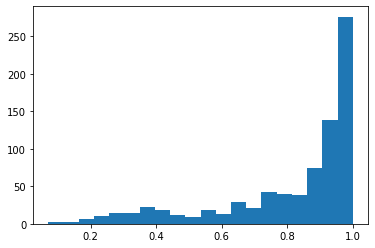

In [24]:
import matplotlib.pyplot as plt
print(f"total number of scenarios: {len(sfs)}.")
plt.hist(sfs, bins=20)
plt.show()

In [25]:
for model in models:
    print(model)
    print(model.signalling_fraction())

                (0, 0) (0, 1) (1, 0) (1, 1)
(furry, sweet) 0.5502 0.0000 0.0000 0.4498
(sweet, lovely) 0.5071 0.0000 0.0000 0.4929
(lovely, furry) 0.0000 0.5297 0.4703 0.0000

0.10044586649798704
                  (0, 0) (0, 1) (1, 0) (1, 1)
(sweet, furry) 0.5003 0.0000 0.0000 0.4997
(furry, friendly) 0.4937 0.0000 0.0000 0.5063
(friendly, sweet) 0.0000 0.4644 0.5356 0.0000

0.07128006133623599
                (0, 0) (0, 1) (1, 0) (1, 1)
(sweet, round) 0.4542 0.0000 0.0000 0.5458
(round, rotten) 0.5073 0.0000 0.0000 0.4927
(rotten, sweet) 0.0000 0.5707 0.4293 0.0000

0.14139175412219152
                (0, 0) (0, 1) (1, 0) (1, 1)
(rotten, round) 0.5723 0.0000 0.0000 0.4277
(round, sweet) 0.4704 0.0000 0.0000 0.5296
(sweet, rotten) 0.0000 0.5425 0.4575 0.0000

0.14457327124249364
                (0, 0) (0, 1) (1, 0) (1, 1)
(rotten, round) 0.5723 0.0000 0.0000 0.4277
(round, sour) 0.4353 0.0000 0.0000 0.5647
(sour, rotten) 0.0000 0.4320 0.5680 0.0000

0.14457327115294494
